In [1]:
import os
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as torchNN
import torch.nn.functional as torchF
import matplotlib.pyplot as plt
import gymnasium as gym

from itertools import count
from IPython import display
from collections import namedtuple, deque
from torchsummary import summary

%matplotlib inline

In [ ]:
#TODO 加入对于时间的观测
'''
思路: 在卷积神经网络之后利用 RNN 进行 Action 的获得
1. CNN + RNN
2. CNN + Liner + RNN
3. CNN -> Flatten -> Liner -> [LinerOutput, Time] -> RNN
'''

In [2]:
Transition = namedtuple('Transition', ('nowState', 'action', 'nextState', 'reward'))
class MemoryPool():
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen = capacity)
    
    def AddMemory(self, *arg):
        self.memory.append(Transition(*arg))
    
    def Sample(self, BATCHSIZE):
        return random.sample(self.memory, BATCHSIZE)

    def __len__(self):
        return len(self.memory)

In [3]:
class Network(torchNN.Module):
    def __init__(self, stateShape, actionNum, hiddenUnits) -> None:
        '''
        stateShape: (height, weight, depth)
        '''
        
        super(Network, self).__init__()

        self.conv1 = torchNN.Sequential(
            torchNN.Conv2d(
                in_channels = stateShape[2],
                out_channels = 16,
                kernel_size = 3,
                stride = 1,
                padding = 2
            ),
            torchNN.LeakyReLU(),
            torchNN.MaxPool2d(2)
        )
        

        self.conv2 = torchNN.Sequential(
            torchNN.Conv2d(
                in_channels = 16,
                out_channels = 32,
                kernel_size = 5,
                stride = 1,
                padding = 2
            ),

            torchNN.LeakyReLU(),
            torchNN.MaxPool2d(2)
        )

        self.liner = torchNN.Sequential(
            torchNN.Linear(32 * 53 * 40, hiddenUnits),
            torchNN.LeakyReLU(),
            torchNN.Linear(hiddenUnits, hiddenUnits // 2),
            torchNN.LeakyReLU(),
            torchNN.Linear(hiddenUnits // 2, actionNum)
        )

    
    def forward(self, inputData):
        x = self.conv1(inputData)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.liner(x)
        return x

In [4]:
class DQNModel():
    def __init__(
        self,
        stateNum,
        actionNum,
        hiddenUnits,
        episold,
        poolCapacity,
        environment,
        learningRate,
        batchSize,
        gamma,
        sigma,
        epsStart,
        epsEnd,
        epsDecay,
    ):
        '''
        Param:
            stateNum: 
            actionNum:
            hiddenUnits:
            episold:
            poolCapacity:
            environment:
            learningRate:
            gamma:
            sigma:
        '''

        self.policyNetwork = Network(stateNum, actionNum, hiddenUnits)
        self.targetNetwork = Network(stateNum, actionNum, hiddenUnits)
        
        self.targetNetwork.load_state_dict(self.policyNetwork.state_dict())

        self.episold = episold
        self.memoryPool = MemoryPool(poolCapacity)
        self.environment = environment
        self.optimizer = torch.optim.Adam(self.policyNetwork.parameters(), lr = learningRate)
        self.lossFunc = torchNN.SmoothL1Loss()                      # use L1 lossfunction
        self.batchSize = batchSize
        self.gamma = gamma
        self.sigma = sigma

        self.epsStart = epsStart
        self.epsEnd = epsEnd
        self.epsDecay = epsDecay
        self.chooseStep = 0

    def LoadNetwork(self, savedPath):
        self.policyNetwork.load_state_dict(torch.load(savedPath))
        self.targetNetwork.load_state_dict(torch.load(savedPath))

    def SaveNetwork(self, savedPath):
        torch.save(self.policyNetwork.state_dict(), savedPath)
    
    def ChooseAction(self, nowState) -> torch.Tensor:
        '''
        Func:
            return the next action agent may take
        Param:
            nowState:   the state agent is in
        Return:
            shape:      (1, 1), the first d is used for 'BatchSize'      
        '''
        eps = self.epsEnd + (self.epsStart - self.epsEnd) * np.exp(-1.0 * self.chooseStep / self.epsDecay)
        self.chooseStep += 1
        if random.random() < eps:
            return torch.tensor([[self.environment.action_space.sample()]], dtype = torch.long)
        
        with torch.no_grad():
            return self.policyNetwork(nowState).max(1).indices.view(1, 1)   

    def OptimizeNetwork(self):
        if len(self.memoryPool) < self.batchSize:
            return

        data = self.memoryPool.Sample(self.batchSize)
        data = Transition(*zip(*data))

        # 剔除结束回合的步子
        noneFinalNextStateMask = torch.tensor( tuple( map( lambda state: state is not None, data.nextState ) ), dtype = torch.bool)     # shape do not change
        noneFinalnextState = torch.cat( [state for state in data.nextState if state is not None] )

        nowStateMemory = torch.cat(data.nowState)
        actionMemory = torch.cat(data.action)
        rewardMemory = torch.cat(data.reward)

        predictQ = self.policyNetwork(nowStateMemory).gather(1, actionMemory)

        targetQ = torch.zeros(self.batchSize)
        with torch.no_grad():
            targetQ[noneFinalNextStateMask] = self.targetNetwork(noneFinalnextState).max(1).values                                      # 求最大值, 但是凭借成BATCHSIZE的大小, 方便进行数学运算
        targetQ = (targetQ * self.gamma) + rewardMemory

        loss = self.lossFunc(targetQ.unsqueeze(1), predictQ)
        
        self.optimizer.zero_grad()
        loss.backward()
        torchNN.utils.clip_grad_value_(self.policyNetwork.parameters(), 100)

        self.optimizer.step()

        return loss.data.numpy()

    def TrainOneEpoch(self, savedPath):
        '''
        Func:
        Return:
        '''
        startState, info = self.environment.reset()
        nowState = np.transpose(startState, (2, 0, 1))
        nowState = torch.tensor(nowState, dtype = torch.float32).unsqueeze(0)
        
        for stepNum in count():
            action = self.ChooseAction(nowState)
            observation, reward, terminated, truncated, _ = self.environment.step(action.item())
            reward = torch.tensor([reward])
            done = terminated or truncated

            observation = np.transpose(observation, (2, 0, 1))
            
            if terminated:
                nextState = None
            else:
                nextState = torch.tensor(observation, dtype = torch.float32).unsqueeze(0)

            self.memoryPool.AddMemory(nowState, action, nextState, reward)

            nowState = nextState

            self.OptimizeNetwork()

            targetNetworkDict = self.targetNetwork.state_dict()
            policyNetworkDict = self.policyNetwork.state_dict()

            for key in policyNetworkDict:
                targetNetworkDict[key] = policyNetworkDict[key] * self.sigma + targetNetworkDict[key] * (1 - self.sigma)
            self.targetNetwork.load_state_dict(targetNetworkDict)

            if (stepNum + 1) % 50 == 0:
                self.SaveNetwork(savedPath)

            if done:
                return stepNum + 1

In [5]:
env = gym.make("ALE/Tetris-v5")
STATENUM = env.observation_space.shape
ACTIONNUM = env.action_space.n
HIDDENUNITS = 128
EPISOLD = 0.6
POOLCAPACITY = 10000
LR = 0.003
BATCHSIZE = 128
GAMMA = 0.9
SIGMA = 0.005
EPOCHES = 10
SAVEDPATH = '../SavedModel/DQN/dqCNN.pth'
CALLBACK = '../CallBack/DQN/dqCNN.csv'
EPSSTART = 0.9
EPSEND = 0.05
EPSDECAY = 1000

s = summary(Network(STATENUM, ACTIONNUM, 128), input_size = (3, 210, 160))

dqnNetwork = DQNModel(
    STATENUM,
    ACTIONNUM,
    HIDDENUNITS,
    EPISOLD,
    POOLCAPACITY,
    env,
    LR,
    BATCHSIZE,
    GAMMA,
    SIGMA,
    EPSSTART,
    EPSEND,
    EPSDECAY,
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 212, 162]             448
         LeakyReLU-2         [-1, 16, 212, 162]               0
         MaxPool2d-3          [-1, 16, 106, 81]               0
            Conv2d-4          [-1, 32, 106, 81]          12,832
         LeakyReLU-5          [-1, 32, 106, 81]               0
         MaxPool2d-6           [-1, 32, 53, 40]               0
            Linear-7                  [-1, 128]       8,683,648
         LeakyReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
        LeakyReLU-10                   [-1, 64]               0
           Linear-11                    [-1, 5]             325
Total params: 8,705,509
Trainable params: 8,705,509
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.38
Forw

In [6]:
if os.path.exists(SAVEDPATH):
    dqnNetwork.LoadNetwork(SAVEDPATH)

history = {
    'step': [],
}

if os.path.exists(CALLBACK):
    backValue = pd.read_csv(CALLBACK)
    history['step'] += list(backValue['step'])
meanPlot = 0
for i in range(EPOCHES):
    step = dqnNetwork.TrainOneEpoch(SAVEDPATH)
    history['step'].append(step)
    meanPlot += step
    # if (i + 1) % 5 == 0:
    dqnNetwork.SaveNetwork(SAVEDPATH)

meanPlot /= EPOCHES
print(meanPlot)
callbackCSV = pd.DataFrame(history)
callbackCSV.to_csv(CALLBACK)

KeyboardInterrupt: 

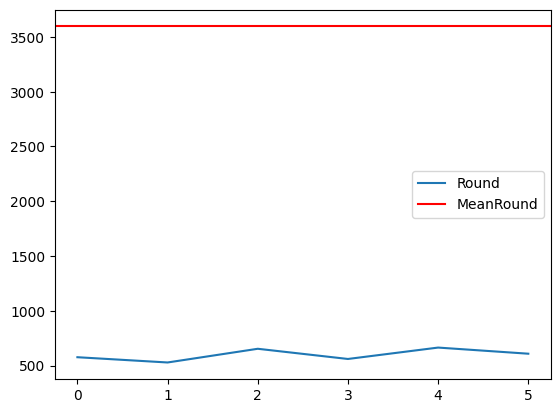

In [7]:
plt.plot(history['step'], label = 'Round')
plt.axhline(y = meanPlot, xmin = 0, xmax = 1, label = 'MeanRound', color = 'red')
plt.legend()
dqnNetwork.SaveNetwork(SAVEDPATH)